In [1]:
pip install transformers==4.30

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


In [2]:
pip install transformers[torch]

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requi

In [4]:
import pandas as pd
import numpy as np
import torch

import re, string, unicodedata
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, roc_auc_score, roc_curve, precision_recall_fscore_support, matthews_corrcoef, classification_report,confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset as HFDataset, DatasetDict, load_metric
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
import nltk

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
def excel_to_df(excel):
    return pd.read_excel(excel)

data = excel_to_df('/content/drive/MyDrive/dataset.xlsx')

In [24]:
data['cleaned'] = data['cleaned'].astype(str)

In [25]:
# Under-sample the dataset
X = data[['cleaned']]
y = data['label']
rus = RandomUnderSampler(random_state=1, replacement=True)
X_new, y_new = rus.fit_resample(X, y)
X_new = X_new.reset_index(drop=True)
y_new = y_new.reset_index(drop=True)


In [26]:
df_new = X_new
df_new['label'] = y_new


In [27]:
# Split data into train/test sets
df_train, df_test = train_test_split(df_new, test_size=0.2, random_state=1)
df_train, df_eval = train_test_split(df_train, test_size=0.2, random_state=1)

In [28]:
# Convert to HuggingFace Datasets
hf_train = HFDataset.from_pandas(df_train)
hf_eval = HFDataset.from_pandas(df_eval)
hf_test = HFDataset.from_pandas(df_test)


In [29]:
dataset_full = DatasetDict({
    'train': hf_train,
    'eval': hf_eval,
    'test': hf_test
})

In [30]:
# Tokenize data
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [31]:
def tokenize_dataset(data):
    return tokenizer(data["cleaned"], padding=True, truncation=True, max_length=512)

dataset_full = dataset_full.map(tokenize_dataset, batched=True)
dataset_full = dataset_full.remove_columns(["cleaned"])

Map:   0%|          | 0/8322 [00:00<?, ? examples/s]

Map:   0%|          | 0/2081 [00:00<?, ? examples/s]

Map:   0%|          | 0/2601 [00:00<?, ? examples/s]

In [32]:
# Prepare BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
import torch
from transformers import AdamW


In [34]:
# Training arguments for BERT model
training_args = TrainingArguments(
    output_dir="results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    report_to="none"
)

In [35]:
# Compute metrics function for BERT model
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    accuracy = accuracy_score(labels, predictions)
    roc_auc = roc_auc_score(labels, predictions)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }


In [36]:
# Train BERT model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_full["train"],
    eval_dataset=dataset_full["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


In [37]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.124100,0.109505,0.975493,0.973807,0.978383,0.976090,0.975426
2,0.044900,0.104515,0.979817,0.983902,0.976504,0.980189,0.979894
3,0.015400,0.117190,0.979337,0.985728,0.973684,0.979669,0.979467
4,0.002100,0.121769,0.980778,0.984848,0.977444,0.981132,0.980856
5,0.000000,0.136140,0.979817,0.988528,0.971805,0.980095,0.980003


TrainOutput(global_step=5205, training_loss=0.045666611625828156, metrics={'train_runtime': 4111.853, 'train_samples_per_second': 10.12, 'train_steps_per_second': 1.266, 'total_flos': 1.09480510135296e+16, 'train_loss': 0.045666611625828156, 'epoch': 5.0})

# Extract BERT embeddings

In [38]:

class BERTEmbeddingsDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }


In [39]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = BERTEmbeddingsDataset(
        texts=df.cleaned.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=4)


In [40]:
data_loader = create_data_loader(df_new, tokenizer, max_len=128, batch_size=16)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [41]:
bert_model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")
bert_model = bert_model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [42]:
def extract_embeddings(data_loader, model, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

In [43]:
X_bert = extract_embeddings(data_loader, bert_model, device)

# Train SVM and Random Forest on BERT embeddings
X_train, X_test, y_train, y_test = train_test_split(X_bert, y_new, test_size=0.2, random_state=42)


  0%|          | 0/813 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 813/813 [01:37<00:00,  8.36it/s]


In [44]:
svm_model = SVC(probability=True,C=1,gamma= 0.1, kernel='linear')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [45]:
svm_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [46]:
svm_pred = svm_model.predict(X_test)
rf_pred = rf_model.predict(X_test)


In [47]:
# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_name} Model - Precision: {precision}, Recall: {recall}, F1: {f1}, Accuracy: {accuracy}")
    return precision, recall, f1, accuracy

In [48]:
pred_output = trainer.predict(test_dataset=dataset_full["test"])

In [49]:
pred_output_eval = trainer.predict(test_dataset=dataset_full["eval"])

In [50]:
pred_label_eval = np.argmax(pred_output_eval.predictions, axis=1)
gt_label_eval = dataset_full["eval"]['label']


In [51]:
pred_label = np.argmax(pred_output.predictions, axis=1)
gt_label = dataset_full["test"]['label']

In [52]:
pred_output.metrics

{'test_loss': 0.09116686880588531,
 'test_accuracy': 0.988081507112649,
 'test_precision': 0.9883086515978177,
 'test_recall': 0.9875389408099688,
 'test_f1': 0.987923646279704,
 'test_roc_auc': 0.9880747095849388,
 'test_runtime': 84.5385,
 'test_samples_per_second': 30.767,
 'test_steps_per_second': 1.928}

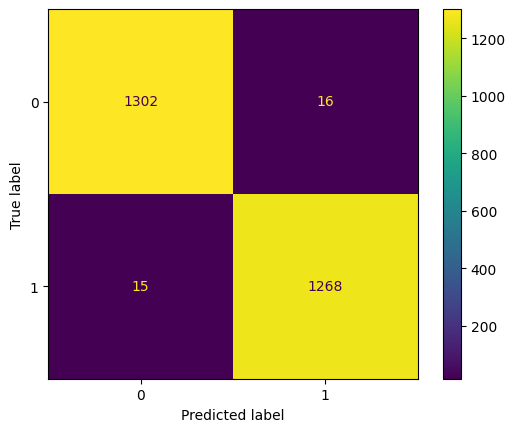

In [53]:
ConfusionMatrixDisplay.from_predictions(pred_label, gt_label);

In [54]:
# take it from tokenized data instead of input
test_data = tokenizer.batch_decode(dataset_full["test"]['input_ids'], skip_special_tokens=True)

# create gt and prediction comparation
pred_compare = []
for i, news in enumerate(test_data):
    pred_compare.append([news, gt_label[i], pred_label[i]])

# turn it to dataframe for easy processing
df_pred_compare = pd.DataFrame(pred_compare)
df_pred_compare = df_pred_compare.rename(columns={0:'news', 1:'labels', 2:'prediction'})
df_pred_compare.to_excel('predictions.xlsx')
df_pred_compare

,news,labels,prediction
0,hadap ribu serang sibar menkumham bentuk csirt...,0,0
1,daftar orang kaya asia jokow milyader usd no l...,1,1
2,koalisi ubah petinggi menasdem berte salim seg...,0,0
3,menit makan bawang mentah kupas garam batu ora...,1,1
4,akun twitter bank bsi bankbsi,1,1
...,...,...,...
2596,memenkumham paspor wni turun filipina anak sta...,0,0
2597,jokow sambut kunjung presiden timor leste jose...,0,0
2598,tegang hubung pkb pbnu nilai bikin partai piki...,0,0
2599,innaa lillaah wa innaa ilaih roo jiuun allahum...,1,1


In [56]:
df_wrong_pred = df_pred_compare[df_pred_compare['labels'] != df_pred_compare['prediction']]
df_pred_compare.to_excel('predictions-wrong.xlsx')

def label_to_str(label_int):
    label = 'Hoax' if label_int == 1 else 'Fakta'
    return f'{label} [{label_int}]'

for i, row in enumerate(df_wrong_pred.values):
    print(f'{i+1} | {row[0]}')

    print(f'>> Ground Truth label: {label_to_str(row[1])}, but predicted as: {label_to_str(row[2])}')
    print()

1 | alas sungguh mulia presiden jokow haru kaesang bantu biaya obat indra bekti
>> Ground Truth label: Hoax [1], but predicted as: Fakta [0]

2 | erti negara dasar sudut negara salah wujud organisasi besar lingkup kutip buku didi warganegara dr baso madiong teman teman negara wilayah dalam diam orang milik tuju hidup beda beda negara unsur dalam tiga unsur salah nama negara tiga unsur lengkap negara tiga unsur unsur kalah aku negara aku negara milik negara ada negara diaku negara negara ahli kelompok erti negara dasar sudut pandang jelas negara alat masyarakat milik kuasa atur hubung manusia masyarakat negara organisasi kuasa hakikat tata kerja kelompok manusia buat sikap sesuai hendak negara kumpul sosial fungsi pelihara tertib hormat pribadi warga negara lindung rakyat cipta sejahtera definisi negara organisasi politik negara sekutu manusia milik ciri khas beda negara sekutu manusia ciri khas daulat anggota negara sifat ikat paksa rangkum buku kembang ilmu negara adab globalisasi dun

In [ ]:
pred_output = trainer.predict(test_dataset=dataset_full["train"])

In [ ]:
pred_label_train = np.argmax(pred_output.predictions, axis=1)
gt_label_train = dataset_full["train"]['label']


In [ ]:
pred_output.metrics

{'test_loss': 0.001292094704695046,
 'test_accuracy': 0.9997596731554914,
 'test_precision': 0.9995187680461982,
 'test_recall': 1.0,
 'test_f1': 0.9997593261131167,
 'test_roc_auc': 0.9997600767754319,
 'test_runtime': 302.0275,
 'test_samples_per_second': 27.554,
 'test_steps_per_second': 1.725}

In [ ]:
pred_output.metrics

{'test_loss': 0.08734465390443802,
 'test_accuracy': 0.9850057670126874,
 'test_precision': 0.97847809377402,
 'test_recall': 0.9914330218068536,
 'test_f1': 0.9849129593810445,
 'test_roc_auc': 0.9850862907060083,
 'test_runtime': 94.2932,
 'test_samples_per_second': 27.584,
 'test_steps_per_second': 1.729}

In [ ]:
# after training
trainer.evaluate(eval_dataset=dataset_full["test"])

{'eval_loss': 0.08734465390443802,
 'eval_accuracy': 0.9850057670126874,
 'eval_precision': 0.97847809377402,
 'eval_recall': 0.9914330218068536,
 'eval_f1': 0.9849129593810445,
 'eval_roc_auc': 0.9850862907060083,
 'eval_runtime': 93.2483,
 'eval_samples_per_second': 27.893,
 'eval_steps_per_second': 1.748,
 'epoch': 5.0}

In [58]:
training_metrics = trainer.state.log_history

In [ ]:
training_metrics

[{'loss': 0.1373,
  'learning_rate': 1.616122840690979e-05,
  'epoch': 0.96,
  'step': 500},
 {'eval_loss': 0.07760564237833023,
  'eval_accuracy': 0.984142239308025,
  'eval_precision': 0.9849482596425212,
  'eval_recall': 0.9840225563909775,
  'eval_f1': 0.9844851904090268,
  'eval_roc_auc': 0.9841450048424898,
  'eval_runtime': 74.0268,
  'eval_samples_per_second': 28.111,
  'eval_steps_per_second': 1.77,
  'epoch': 1.0,
  'step': 521},
 {'loss': 0.0436,
  'learning_rate': 1.2322456813819578e-05,
  'epoch': 1.92,
  'step': 1000},
 {'eval_loss': 0.08782035112380981,
  'eval_accuracy': 0.9817395482940894,
  'eval_precision': 0.9867172675521821,
  'eval_recall': 0.9774436090225563,
  'eval_f1': 0.9820585457979225,
  'eval_roc_auc': 0.981838815327404,
  'eval_runtime': 73.8958,
  'eval_samples_per_second': 28.161,
  'eval_steps_per_second': 1.773,
  'epoch': 2.0,
  'step': 1042},
 {'loss': 0.0163,
  'learning_rate': 8.483685220729368e-06,
  'epoch': 2.88,
  'step': 1500},
 {'eval_loss':

In [59]:
import matplotlib.pyplot as plt

# Ekstraksi loss dan akurasi dari metrik pelatihan
epochs = []
train_loss = []
eval_loss = []
train_accuracy = []
eval_accuracy = []

for entry in training_metrics:
    if 'epoch' in entry:
        epochs.append(entry['epoch'])
    if 'loss' in entry:
        train_loss.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
    if 'eval_accuracy' in entry:
        eval_accuracy.append(entry['eval_accuracy'])
    if 'accuracy' in entry:
        train_accuracy.append(entry['test_accuracy'])

In [60]:
# Ensure the lists are of the same length by appending NaNs where necessary
max_len = max(len(epochs), len(train_loss), len(eval_loss), len(train_accuracy), len(eval_accuracy))
while len(train_loss) < max_len:
    train_loss.append(None)
while len(eval_loss) < max_len:
    eval_loss.append(None)
while len(train_accuracy) < max_len:
    train_accuracy.append(None)
while len(eval_accuracy) < max_len:
    eval_accuracy.append(None)


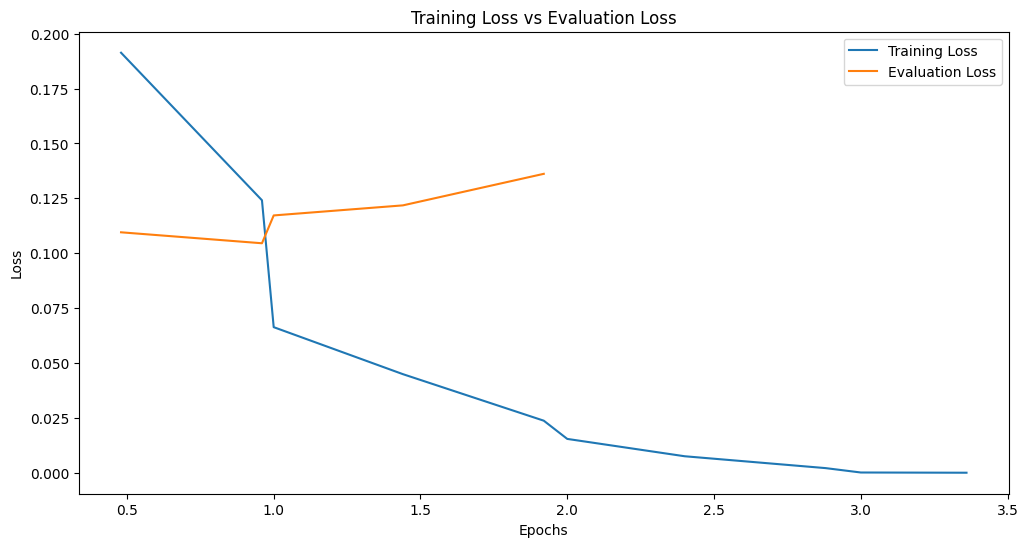

In [61]:
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, eval_loss, label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Evaluation Loss')
plt.legend(loc="upper right")
plt.show()

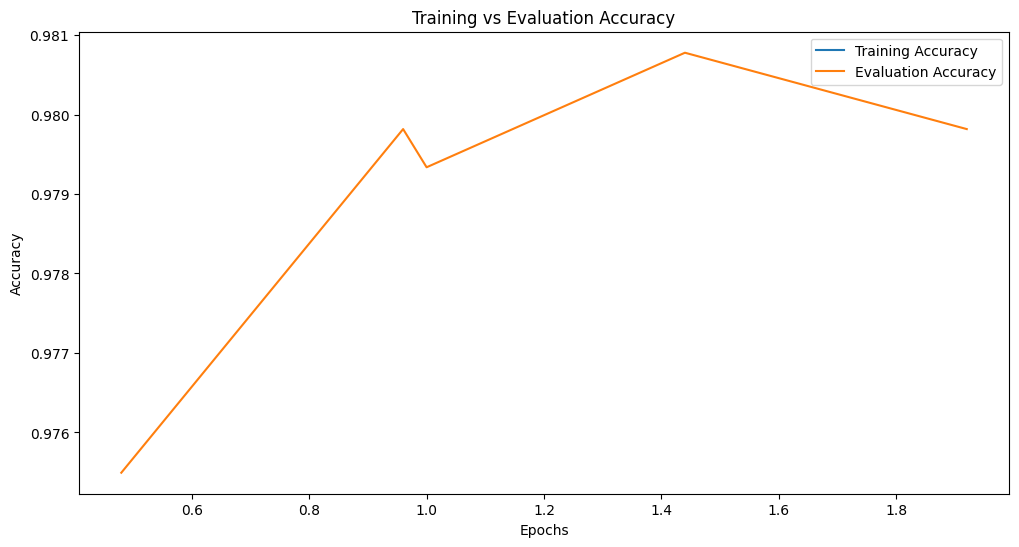

In [62]:
# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, eval_accuracy, label='Evaluation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Evaluation Accuracy')
plt.legend()
plt.show()

In [63]:
bert_accuracy = accuracy_score(gt_label, pred_label)
precision = precision_score(gt_label, pred_label)
recall = recall_score(gt_label, pred_label)
f1 = f1_score(gt_label, pred_label)
mcc = matthews_corrcoef(gt_label, pred_label)

In [64]:
svm_accuracy = accuracy_score(y_test, svm_pred)

In [65]:
rf_accuracy = accuracy_score(y_test, rf_pred)

In [66]:
vm_metrics = evaluate_model(y_test, svm_pred, "SVM")
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")


SVM Model - Precision: 0.9492307692307692, Recall: 0.954369682907966, F1: 0.9517932896259158, Accuracy: 0.9519415609381008
Random Forest Model - Precision: 0.9390432098765432, Recall: 0.9412219644238206, F1: 0.9401313248358439, Accuracy: 0.9404075355632449


In [67]:
# ROC Curve
svm_probs = svm_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]
bert_probs = trainer.predict(test_dataset=dataset_full["test"]).predictions[:, 1]

In [68]:
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_pred)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred)
bert_fpr, bert_tpr, _ = roc_curve(gt_label, pred_label)

In [69]:
svm_roc_auc = roc_auc_score(y_test, svm_pred)
rf_roc_auc = roc_auc_score(y_test, rf_pred)

In [70]:
bert_roc_auc = roc_auc_score(gt_label,pred_label)

In [71]:
# Confusion Matrices
bert_conf_matrix = confusion_matrix(gt_label, pred_label)
print(f'confusion_matrix bert = {bert_conf_matrix}')
svm_conf_matrix = confusion_matrix(y_test, svm_pred)
print(f'confusion_matrix svm = {svm_conf_matrix}')
rf_conf_matrix = confusion_matrix(y_test, rf_pred)
print(f'confusion_matrix rf = {rf_conf_matrix}')

confusion_matrix bert = [[1302   15]
 [  16 1268]]
confusion_matrix svm = [[1242   66]
 [  59 1234]]
confusion_matrix rf = [[1229   79]
 [  76 1217]]


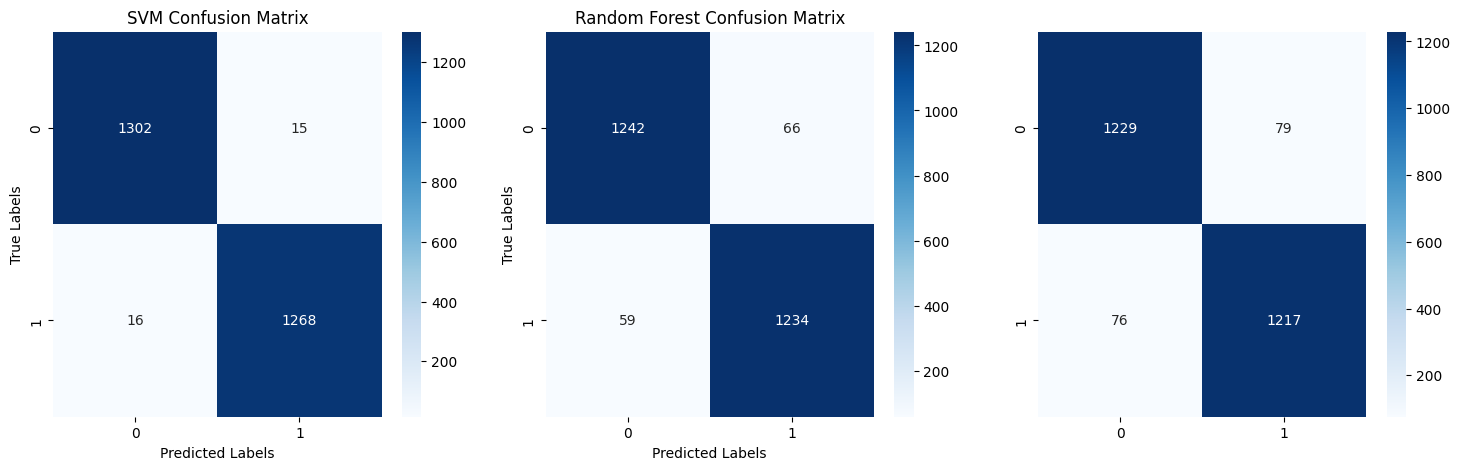

In [72]:
# Confusion Matrix Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(bert_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax2.set_title('BERT Confusion Matrix')
ax2.set_xlabel('Predicted Labels')
ax2.set_ylabel('True Labels')

sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax1.set_title('SVM Confusion Matrix')
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('True Labels')

sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax2.set_title('Random Forest Confusion Matrix')
ax2.set_xlabel('Predicted Labels')
ax2.set_ylabel('True Labels')

plt.show()

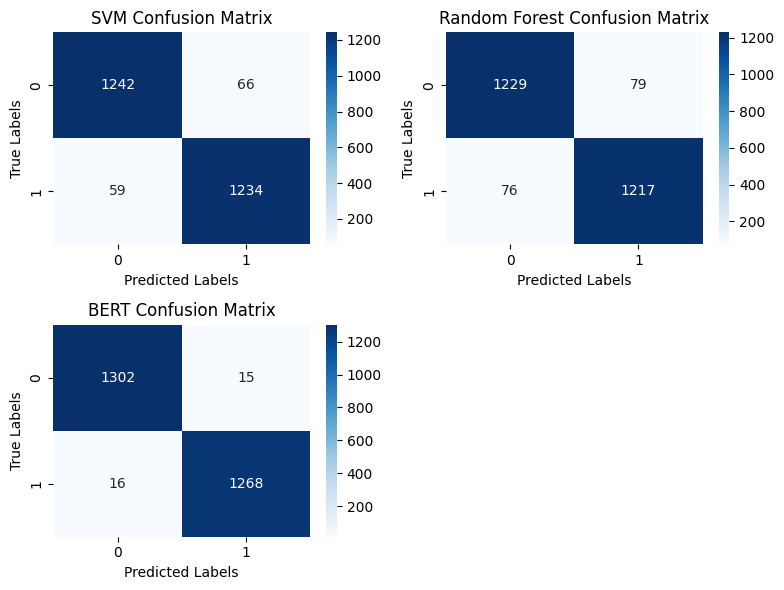

In [73]:
# Create 2x2 subplots (only use three subplots)
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# SVM Confusion Matrix
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[0, 0])
axs[0, 0].set_title('SVM Confusion Matrix')
axs[0, 0].set_xlabel('Predicted Labels')
axs[0, 0].set_ylabel('True Labels')

# Random Forest Confusion Matrix
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[0, 1])
axs[0, 1].set_title('Random Forest Confusion Matrix')
axs[0, 1].set_xlabel('Predicted Labels')
axs[0, 1].set_ylabel('True Labels')

# BERT Confusion Matrix
sns.heatmap(bert_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[1, 0])
axs[1, 0].set_title('BERT Confusion Matrix')
axs[1, 0].set_xlabel('Predicted Labels')
axs[1, 0].set_ylabel('True Labels')

# Hide the unused subplot
fig.delaxes(axs[1, 1])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

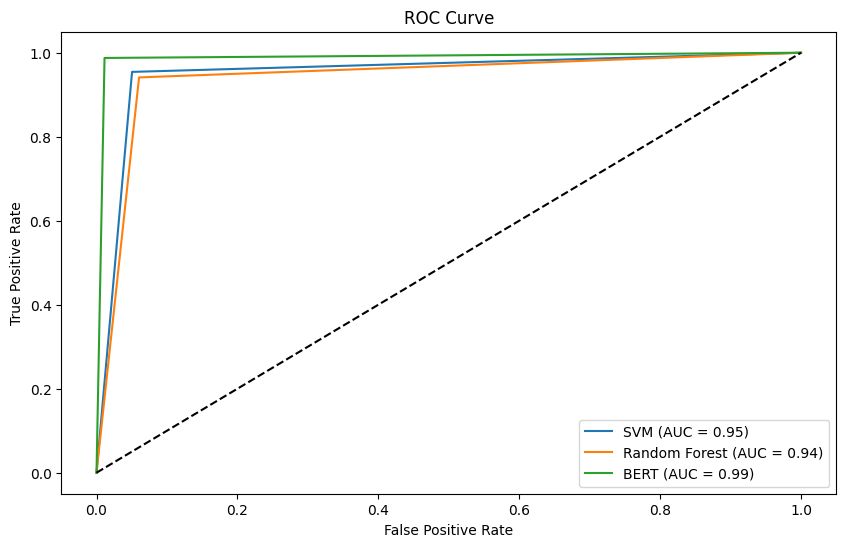

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_roc_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f})')
plt.plot(bert_fpr, bert_tpr, label=f'BERT (AUC = {bert_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [75]:
models = ['SVM', 'Random Forest', 'BERT']
accuracy_scores = [svm_accuracy, rf_accuracy, bert_accuracy]

In [76]:
print('BERT')
print(classification_report(gt_label, pred_label))
print('RANDOM FOREST')
print(classification_report(y_test, rf_pred))
print('SVM')
print(classification_report(y_test, svm_pred))

BERT
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1317
           1       0.99      0.99      0.99      1284

    accuracy                           0.99      2601
   macro avg       0.99      0.99      0.99      2601
weighted avg       0.99      0.99      0.99      2601

RANDOM FOREST
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1308
           1       0.94      0.94      0.94      1293

    accuracy                           0.94      2601
   macro avg       0.94      0.94      0.94      2601
weighted avg       0.94      0.94      0.94      2601

SVM
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1308
           1       0.95      0.95      0.95      1293

    accuracy                           0.95      2601
   macro avg       0.95      0.95      0.95      2601
weighted avg       0.95      0.95      0.95      26

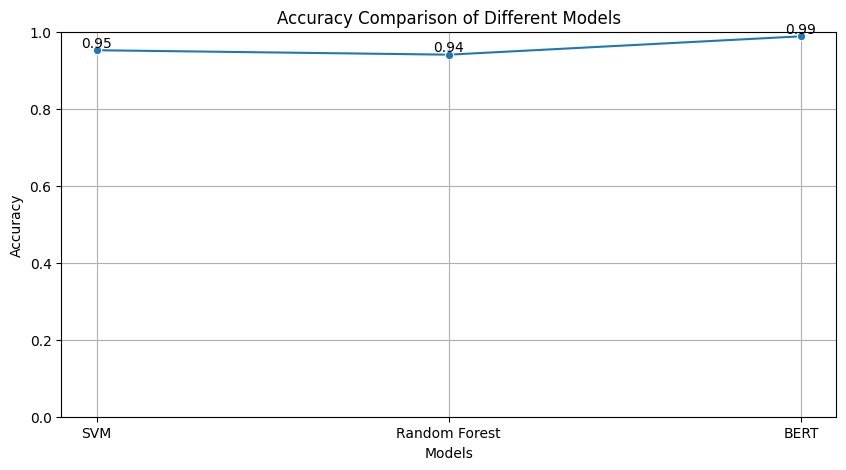

In [77]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=models, y=accuracy_scores, marker='o')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0, 1)  # Set y-axis limits to range from 0 to 1 for better visibility
plt.grid(True)

for i in range(len(models)):
    plt.text(i, accuracy_scores[i], f'{accuracy_scores[i]:.2f}', ha='center', va='bottom')

plt.show()